# Check GPU Type

In [ ]:
!nvidia-smi
# !pip uninstall torchsummary
!pip install torchsummary

Thu Apr 25 14:26:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Get Data and Pretrain model
Download the data directly from Kaggle


In [ ]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/food11.zip"

In [ ]:
! rm -r __MACOSX/

# Import Packages

In [ ]:
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random
import pdb

In [ ]:
cfg = {
    'dataset_root': './food11/',
    'save_dir': '/content/drive/MyDrive/',
    'exp_name': "medium_baseline_q",
    'batch_size': 64,
    'lr': 3e-4,
    'seed': 20220013,
    'loss_fn_type': 'KD', # simple baseline: CE, medium baseline: KD. See the Knowledge_Distillation part for more information.
    'weight_decay': 1e-5,
    'grad_norm_max': 10,
    'n_epochs': 15, # train more steps to pass the medium baseline.
    'patience': 10,
    'quantization': True,
}

In [ ]:
myseed = cfg['seed']  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
random.seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

save_path = os.path.join(cfg['save_dir'], cfg['exp_name']) # create saving directory
os.makedirs(save_path, exist_ok=True)

# define simple logging functionality
log_fw = open(f"{save_path}/log.txt", 'w') # open log file to save log outputs
def log(text):     # define a logging function to trace the training process
    print(text)
    log_fw.write(str(text)+'\n')
    log_fw.flush()

log(cfg)

{'dataset_root': './food11/', 'save_dir': '/content/drive/MyDrive/', 'exp_name': 'medium_baseline_q', 'batch_size': 64, 'lr': 0.0003, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 1e-05, 'grad_norm_max': 10, 'n_epochs': 15, 'patience': 10, 'quantization': True}


# Transforms

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_tfm = transforms.Compose([
    # add some useful transform or augmentation here, according to your experience in HW3.
    # transforms.Resize(256),  # You can change this
    # transforms.CenterCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
    # The training input size of the provided teacher model is (3, 224, 224).
    # Thus, Input size other then 224 might hurt the performance. please be careful.
    # transforms.RandomHorizontalFlip(), # You can change this.
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(7, (0.1, 1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5, hue=(-0.05, 0.05)),
    transforms.ToTensor(),
    normalize,
])


# Datasets

In [ ]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im,label

# Dataloader

In [ ]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./food11/training", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./food11/validation", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

# Visualize Dataset

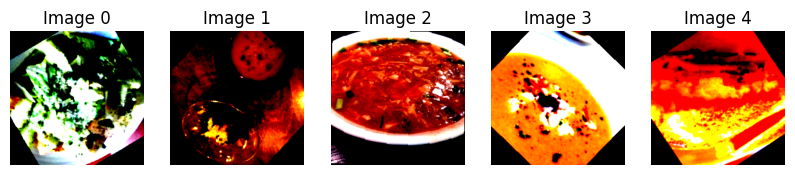

In [ ]:
import matplotlib.pyplot as plt

# train_set = FoodDataset("./food11/sample", tfm=train_tfm)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
imgs = np.zeros([5,3,224,224])
for batch in train_loader:
    img, labels = batch
    # print(img.shape)
    img = img.numpy()
    imgs = img[0:5]

fig = plt.figure(figsize=(10, 3))
for i in range(5):
    fig.add_subplot(1, 5, i+1)
    show_img = np.zeros([imgs.shape[2], imgs.shape[3], 3])
    show_img[:, :, 0] = imgs[i][0, :, :]
    show_img[:, :, 1] = imgs[i][1, :, :]
    show_img[:, :, 2] = imgs[i][2, :, :]
    plt.imshow(show_img)
    plt.axis('off')
    plt.title(f"Image {i}")
plt.show()

# Model

In [ ]:
# Example implementation of Depthwise and Pointwise Convolution
def dwpw_conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels), #depthwise convolution
        nn.Conv2d(in_channels, out_channels, 1), # pointwise convolution
    )

class ResConv(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
        self.fadd = torch.nn.quantized.FloatFunctional()

    def forward(self, inputs):
        return self.fadd.add(self.module(inputs), inputs)

def res_conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    layer = nn.Sequential(
        ResConv(nn.Sequential(dwpw_conv(in_channels, in_channels, kernel_size, stride=stride, padding=padding),
                              nn.BatchNorm2d(in_channels),
                              nn.ReLU())),
        nn.Conv2d(in_channels, out_channels, 1), # pointwise convolution
        # ResConv(nn.Sequential(dwpw_conv(out_channels, out_channels, kernel_size, stride=stride, padding=padding),
        #                       nn.BatchNorm2d(out_channels),
        #                       nn.ReLU())),
    )
    return layer

In [ ]:
class StudentNet(nn.Module):
    def __init__(self):
      super().__init__()

      # ---------- TODO ----------
      # Modify your model architecture

      self.cnn = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),

        nn.Conv2d(16, 32, 3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),

        # nn.Conv2d(4, 16, 3),
        # dwpw_conv(16, 32, 3, stride=1, padding=1),
        # nn.BatchNorm2d(32),
        # nn.ReLU(),
        res_conv(32, 64, 3, stride=1, padding=1),
        nn.MaxPool2d(2, 2, 0),

        # nn.Conv2d(16, 64, 3),
        # dwpw_conv(32, 64, 3, stride=1, padding=1),
        # nn.BatchNorm2d(64),
        # nn.ReLU(),
        res_conv(64, 128, 3, stride=1, padding=1),
        nn.MaxPool2d(2, 2, 0),

        # nn.Conv2d(64, 84, 3),
        # dwpw_conv(128, 128, 3, stride=1, padding=1),
        # nn.BatchNorm2d(128),
        # nn.ReLU(),
        res_conv(128, 140, 3, stride=1, padding=1),
        nn.MaxPool2d(2, 2, 0),

        # dwpw_conv(128, 224, 3, stride=1, padding=1),
        # nn.BatchNorm2d(224),
        # nn.ReLU(),

        # Here we adopt Global Average Pooling for various input size.
        nn.AdaptiveAvgPool2d((1, 1)),
      )
      self.fc = nn.Sequential(
        # nn.Dropout(0.2, inplace=True),
        # nn.Linear(128, 64),
        # nn.ReLU(inplace=True),
        nn.Linear(140, 11)
      )

    def forward(self, x):
      out = self.cnn(x)
      out = out.view(out.size()[0], -1)
      return self.fc(out)

def get_student_model(): # This function should have no arguments so that we can get your student network by directly calling it.
    # you can modify or do anything here, just remember to return an nn.Module as your student network.
    student_model = StudentNet()
    return student_model

# End of definition of your student model and the get_student_model API
# Please copy-paste the whole code block, including the get_student_model function.

In [ ]:
# DO NOT modify this block and please make sure that this block can run sucessfully.
student_model = get_student_model()
summary(student_model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           4,640
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]             320
            Conv2d-9         [-1, 32, 112, 112]           1,056
      BatchNorm2d-10         [-1, 32, 112, 112]              64
             ReLU-11         [-1, 32, 112, 112]               0
         Identity-12         [-1, 32, 112, 112]               0
          ResConv-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 64, 1

In [ ]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
teacher_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
# print(model)
teacher_model.classifier =  nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(1280, 1000),
    nn.ReLU(inplace=True),
    nn.Linear(1000, 11)
)
# summary(teacher_model, (3, 224, 224), device='cpu')

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:05<00:00, 15.6MB/s]


# Training Teacher model

In [ ]:
# "cuda" only when GPUs are available.
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = Classifier().to(device)
teacher_model = teacher_model.to(device)

# The number of batch size.
batch_size = cfg['batch_size']

# The number of training epochs.
n_epochs = 6

# If no improvement in 'patience' epochs, early stop.
patience = 3

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    teacher_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = teacher_model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(teacher_model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)


    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    teacher_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = teacher_model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc and valid_acc > 0.86533:
        with open(f"./teacher_model_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./teacher_model_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc and valid_acc > 0.86533:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(teacher_model.state_dict(), f"teacher_model_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 001/006 ] loss = 0.35753, acc = 0.88081


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 001/006 ] loss = 0.47628, acc = 0.85558
[ Valid | 001/006 ] loss = 0.47628, acc = 0.85558


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 002/006 ] loss = 0.33395, acc = 0.88984


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 002/006 ] loss = 0.50144, acc = 0.83900
[ Valid | 002/006 ] loss = 0.50144, acc = 0.83900


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 003/006 ] loss = 0.32749, acc = 0.89145


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 003/006 ] loss = 0.49600, acc = 0.84786
[ Valid | 003/006 ] loss = 0.49600, acc = 0.84786


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 004/006 ] loss = 0.30225, acc = 0.89750


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 004/006 ] loss = 0.57171, acc = 0.83272
[ Valid | 004/006 ] loss = 0.57171, acc = 0.83272
No improvment 3 consecutive epochs, early stopping


# Test teacher network

In [ ]:
# use pretrained teacher net
! cp /content/drive/MyDrive/Colab\ Notebooks/ML2023_NN_Compression/teacher_model_best.ckpt ./

In [ ]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
test_set = FoodDataset("./food11/evaluation", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
teacher_model = teacher_model.to(device)
teacher_model.load_state_dict(torch.load("./teacher_model_best.ckpt", map_location=device))
teacher_model.eval()
with torch.no_grad():
    test_accs = []
    for imgs, labels in tqdm(test_loader):
        test_pred = teacher_model(imgs.to(device))
        # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        acc = (test_pred.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)
    test_acc = sum(test_accs) / len(test_accs)

    # Print the information.
    print(f"[ Test ] acc = {test_acc:.5f}")

  0%|          | 0/53 [00:00<?, ?it/s]

[ Test ] acc = 0.88344


# Prepare to Quantize Student Model
Reference:
- https://pytorch.org/blog/quantization-in-practice/#quantization-aware-training-qat
- https://imprld01.github.io/blogg/2021/12/10/note_of_quantization_aware_training_in_pytorch/
- https://zhuanlan.zhihu.com/p/299108528

In [ ]:
! cp /content/drive/MyDrive/Colab\ Notebooks/ML2023_NN_Compression/student_best.ckpt ./

In [ ]:
if cfg['quantization']:
    # check layer name to fuse modules
    # for name, module in student_model.named_modules():
    #     print(name, module)

    student_model.load_state_dict(torch.load(f"./student_best.ckpt", map_location='cpu'))
    student_model.eval()

    """Fuse modules"""
    student_model = torch.quantization.fuse_modules(student_model, ['cnn.0','cnn.1','cnn.2'], inplace=False)
    student_model = torch.quantization.fuse_modules(student_model, ['cnn.3','cnn.4','cnn.5'], inplace=False)
    for layer_idx in [7, 9, 11]:
      student_model = torch.quantization.fuse_modules(student_model, [f'cnn.{layer_idx}.0.module.0.1',
                                                                       f'cnn.{layer_idx}.0.module.1',
                                                                       f'cnn.{layer_idx}.0.module.2'], inplace=False)

    """Insert stubs"""
    student_model.cnn = nn.Sequential(torch.quantization.QuantStub(),
                                      *student_model.cnn,
                                      torch.quantization.DeQuantStub())
    student_model.fc = nn.Sequential(torch.quantization.QuantStub(),
                                      *student_model.fc,
                                      torch.quantization.DeQuantStub())
    student_model.to('cpu').eval()
    # summary(student_model, (3, 224, 224), device='cpu')
    print(student_model)

StudentNet(
  (cnn): Sequential(
    (0): QuantStub()
    (1): ConvReLU2d(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Identity()
    (3): Identity()
    (4): ConvReLU2d(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
            (1): ConvReLU2d(
              (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (1): ReLU()
            )
          )
          (1): Identity()
          (2): Identity()
        )
        (fadd): FloatFunctional(
          (activation_post_process): Identity()
        )
      )
      (1): Conv2d(32, 64, kernel_siz

# Try Static Quantization first

In [ ]:
student_model.qconfig = torch.quantization.get_default_qconfig("x86")
student_model = torch.quantization.prepare(student_model, inplace=False)
# print(student_model)

StudentNet(
  (cnn): Sequential(
    (0): QuantStub(
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (1): ConvReLU2d(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (2): Identity()
    (3): Identity()
    (4): ConvReLU2d(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): Conv2d(
              32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32
              (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
        

In [ ]:
# calibrate model
for imgs, _ in tqdm(test_loader):
        _ = student_model(imgs.to('cpu'))
# print(student_model)

  0%|          | 0/53 [00:00<?, ?it/s]

StudentNet(
  (cnn): Sequential(
    (0): QuantStub(
      (activation_post_process): HistogramObserver(min_val=-2.1179039478302, max_val=2.640000104904175)
    )
    (1): ConvReLU2d(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver(min_val=0.0, max_val=15.771431922912598)
    )
    (2): Identity()
    (3): Identity()
    (4): ConvReLU2d(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (activation_post_process): HistogramObserver(min_val=0.0, max_val=10.680200576782227)
    )
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): Conv2d(
              32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32
              (activation_post_process):

In [36]:
student_model = torch.quantization.convert(student_model, inplace=False)
# print(student_model)
# Go to testing code

StudentNet(
  (cnn): Sequential(
    (0): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): QuantizedConvReLU2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.07731213420629501, zero_point=0, padding=(1, 1))
    (2): Identity()
    (3): Identity()
    (4): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.040282342582941055, zero_point=0, padding=(1, 1))
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.04729405418038368, zero_point=55, padding=(1, 1), groups=32)
            (1): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.04906511306762695, zero_point=0)
          )
          (1): Identity()
          (2): Identity()
        )
        (fadd): QFun

# Prepare QAT (Quantized Aware Training)

In [ ]:
student_model.train()
student_model.qconfig = torch.quantization.get_default_qconfig("x86")
student_model = torch.quantization.prepare_qat(student_model, inplace=False)  # Don't use inplace, ref:https://imprld01.github.io/blogg/2021/12/10/note_of_quantization_aware_training_in_pytorch/
# summary(student_model, (3, 224, 224), device='cpu')
print(student_model)

StudentNet(
  (cnn): Sequential(
    (0): QuantStub(
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (1): ConvReLU2d(
      3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (2): Identity()
    (3): Identity()
    (4): ConvReLU2d(
      16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): Conv2d(
              32, 32, kernel_size=(3, 3), stride=(1, 1)

# Knowledge distillation loss

In [ ]:
# Implement the loss function with KL divergence loss for knowledge distillation.
def loss_fn_kd(student_logits, labels, teacher_logits, alpha=0.5, temperature=1.0):
    # ------------TODO-------------
    # Refer to the above formula and finish the loss function for knowkedge distillation using KL divergence loss and CE loss.
    # If you have no idea, please take a look at the provided useful link above.
    loss_ce = F.cross_entropy(student_logits, labels)
    student_logits = student_logits / temperature
    teacher_logits = teacher_logits / temperature
    loss_kl = F.kl_div(F.log_softmax(student_logits, dim=-1),
                       F.softmax(teacher_logits, dim=-1),
                       reduction='batchmean')
    loss = alpha * loss_ce + (1 - alpha) * (temperature**2) * loss_kl
    # print(loss_ce, loss_kl)
    return loss

# Train student network



In [ ]:
# choose the loss function by the config
if cfg['loss_fn_type'] == 'CE':
    # For the classification task, we use cross-entropy as the default loss function.
    loss_fn = nn.CrossEntropyLoss() # loss function for simple baseline.

if cfg['loss_fn_type'] == 'KD': # KD stands for knowledge distillation
    print("use KD loss")
    loss_fn = loss_fn_kd # implement loss_fn_kd for the report question and the medium baseline.

# You can also adopt other types of knowledge distillation techniques for strong and boss baseline, but use function name other than `loss_fn_kd`
# For example:
# def loss_fn_custom_kd():
#     pass
# if cfg['loss_fn_type'] == 'custom_kd':
#     loss_fn = loss_fn_custom_kd

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
log(f"device: {device}")

# The number of training epochs and patience.
n_epochs = cfg['n_epochs']
patience = cfg['patience'] # If no improvement in 'patience' epochs, early stop
log(f"n_epochs: {n_epochs}, patience:{patience}")

use KD loss
device: cuda
n_epochs: 15, patience:10


In [ ]:
# Initialize a model, and put it on the device specified.
student_model.to(device)
teacher_model.to(device) # MEDIUM BASELINE

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(student_model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0.0

teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE

        logits = student_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
        # loss = loss_fn(logits, labels) # SIMPLE BASELINE

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=cfg['grad_norm_max'])

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append(loss.item() * train_batch_len)
        train_accs.append(acc)
        train_lens.append(train_batch_len)

    train_loss = sum(train_loss) / sum(train_lens)
    train_acc = sum(train_accs) / sum(train_lens)

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    student_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = student_model(imgs)
            teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

        # We can still compute the loss (but not the gradient).
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
        # loss = loss_fn(logits, labels) # SIMPLE BASELINE

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        valid_loss.append(loss.item() * batch_len)
        valid_accs.append(acc)
        valid_lens.append(batch_len)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / sum(valid_lens)
    valid_acc = sum(valid_accs) / sum(valid_lens)

    # update logs

    if valid_acc > best_acc:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        log(f"Best model found at epoch {epoch+1}, saving model")
        if cfg['quantization']:
            torch.save(student_model.state_dict(), f"{save_path}/student_best_q_train.ckpt")
        else:
            torch.save(student_model.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
# log_fw.close()

  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 001/015 ] loss = 0.83049, acc = 0.67038


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 001/015 ] loss = 0.79347, acc = 0.70175 -> best
Best model found at epoch 1, saving model


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 002/015 ] loss = 0.80029, acc = 0.68751


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 002/015 ] loss = 0.85253, acc = 0.68309


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 003/015 ] loss = 0.81078, acc = 0.68397


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 003/015 ] loss = 0.78280, acc = 0.70758 -> best
Best model found at epoch 3, saving model


  0%|          | 0/155 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Save Quantized Network

In [ ]:
if cfg['quantization']:
    student_model.eval()
    student_model.load_state_dict(torch.load(f"{save_path}/student_best_q_train.ckpt", map_location=device))
    student_model.to('cpu')
    student_model = torch.quantization.convert(student_model, inplace=False)
    torch.save(student_model.state_dict(), f"{save_path}/student_best_q_convert.ckpt")

# Test Student network


In [ ]:
torch.cuda.empty_cache()
device = "cuda" if (torch.cuda.is_available() and not cfg['quantization']) else "cpu"
student_model.eval()
student_model.to(device)
if cfg['quantization']:
    student_model.qconfig = torch.quantization.get_default_qconfig("x86")
    student_model = torch.quantization.prepare(student_model, inplace=False)
    student_model = torch.quantization.convert(student_model, inplace=False)
    student_model.load_state_dict(torch.load(f"{save_path}/student_best_q_convert.ckpt", map_location=device))
else:
    student_model.load_state_dict(torch.load(f"{save_path}/student_best.ckpt"))
# summary(student_model, (3, 224, 224), device='cpu')
print(student_model)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:1263: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


StudentNet(
  (cnn): Sequential(
    (0): Quantize(scale=tensor([0.0374]), zero_point=tensor([57]), dtype=torch.quint8)
    (1): QuantizedConvReLU2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.102459616959095, zero_point=0, padding=(1, 1))
    (2): Identity()
    (3): Identity()
    (4): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05421146750450134, zero_point=0, padding=(1, 1))
    (5): Identity()
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): ResConv(
        (module): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05855174362659454, zero_point=51, padding=(1, 1), groups=32)
            (1): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.062411222606897354, zero_point=0)
          )
          (1): Identity()
          (2): Identity()
        )
        (fadd): QFunct

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:404: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [37]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
torch.cuda.empty_cache()
device = "cuda" if (torch.cuda.is_available() and not cfg['quantization']) else "cpu"
test_set = FoodDataset("./food11/evaluation", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
with torch.no_grad():
    test_accs = []
    for imgs, labels in tqdm(test_loader):
        test_pred = student_model(imgs.to(device))
        # test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        acc = (test_pred.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)
    test_acc = sum(test_accs) / len(test_accs)

    # Print the information.
    print(f"[ Test ] acc = {test_acc:.5f}")

  0%|          | 0/53 [00:00<?, ?it/s]

[ Test ] acc = 0.71323


In [46]:
print(student_model.cnn[1].weight()[0])
print(torch.int_repr(student_model.cnn[1].weight()[0]).numpy())

tensor([[[-0.0662, -0.0930, -0.0331],
         [ 0.0276, -0.0307, -0.0496],
         [-0.0520,  0.0260,  0.0496]],

        [[-0.0071, -0.0780, -0.0906],
         [-0.0678, -0.0024, -0.1009],
         [ 0.0410, -0.0922, -0.0851]],

        [[ 0.0315,  0.0118,  0.0591],
         [ 0.0039, -0.0228,  0.0536],
         [-0.0221, -0.0142,  0.0244]]], size=(3, 3, 3), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.0007878950564190745,
       zero_point=0)
[[[ -84 -118  -42]
  [  35  -39  -63]
  [ -66   33   63]]

 [[  -9  -99 -115]
  [ -86   -3 -128]
  [  52 -117 -108]]

 [[  40   15   75]
  [   5  -29   68]
  [ -28  -18   31]]]
